In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [2]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [3]:
import os

DATA_DIR = "./Tiger Dataset"
print(os.listdir(DATA_DIR))

['train']


In [4]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [5]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [ ]:
show_batch(train_dl)

C:\Users\2021PITAI260\AppData\Local\anaconda3\Lib\site-packages\torch\cuda\__init__.py:193: UserWarning: 
    Found GPU0 GeForce GT 730 which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(


In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cpu')

In [10]:
train_dl = DeviceDataLoader(train_dl, device)

In [11]:
import torch.nn as nn

In [12]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [13]:
discriminator = to_device(discriminator, device)

In [14]:
latent_size = 128

In [15]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

torch.Size([128, 3, 64, 64])


In [16]:
generator = to_device(generator, device)

In [17]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [18]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [19]:
from torchvision.utils import save_image

In [20]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [21]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [22]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


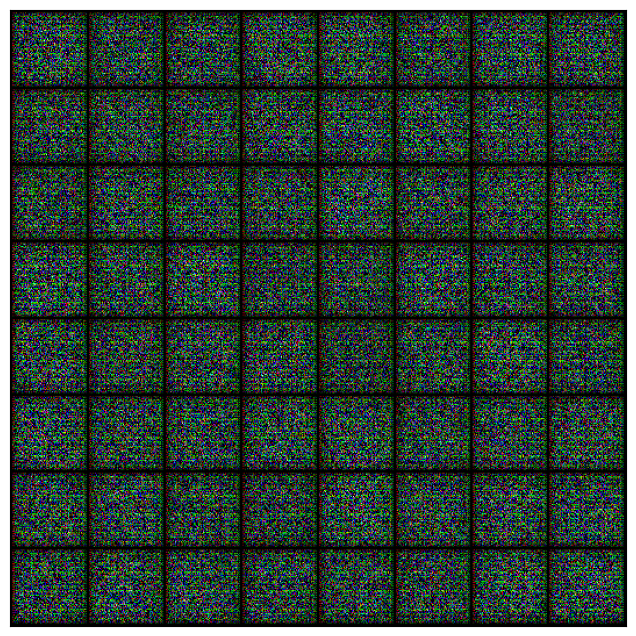

In [25]:
save_samples(0, fixed_latent)

In [23]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [24]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [25]:
lr = 0.0002
epochs = 25

In [29]:
history = fit(epochs, lr)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 3.1708, loss_d: 1.4280, real_score: 0.5161, fake_score: 0.5212
Saving generated-images-0001.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 3.3693, loss_d: 1.1037, real_score: 0.6992, fake_score: 0.5101
Saving generated-images-0002.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 3.8349, loss_d: 0.9191, real_score: 0.6558, fake_score: 0.3719
Saving generated-images-0003.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 4.2222, loss_d: 0.7354, real_score: 0.7026, fake_score: 0.3034
Saving generated-images-0004.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 5.4416, loss_d: 0.7691, real_score: 0.7720, fake_score: 0.3862
Saving generated-images-0005.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 5.3750, loss_d: 0.5501, real_score: 0.7202, fake_score: 0.1898
Saving generated-images-0006.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 6.7993, loss_d: 0.5525, real_score: 0.8237, fake_score: 0.2931
Saving generated-images-0007.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 6.4014, loss_d: 0.3960, real_score: 0.8087, fake_score: 0.1620
Saving generated-images-0008.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 8.1540, loss_d: 0.5961, real_score: 0.8559, fake_score: 0.3469
Saving generated-images-0009.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 6.2575, loss_d: 0.3223, real_score: 0.7775, fake_score: 0.0636
Saving generated-images-0010.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 9.7597, loss_d: 1.1033, real_score: 0.8965, fake_score: 0.6149
Saving generated-images-0011.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 8.2971, loss_d: 0.3027, real_score: 0.7505, fake_score: 0.0086
Saving generated-images-0012.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 8.0882, loss_d: 0.4672, real_score: 0.8694, fake_score: 0.2710
Saving generated-images-0013.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 8.2693, loss_d: 0.2975, real_score: 0.8702, fake_score: 0.1428
Saving generated-images-0014.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 8.8239, loss_d: 0.3111, real_score: 0.8766, fake_score: 0.1598
Saving generated-images-0015.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 7.4599, loss_d: 0.1967, real_score: 0.8707, fake_score: 0.0547
Saving generated-images-0016.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 11.6656, loss_d: 0.5225, real_score: 0.9149, fake_score: 0.3425
Saving generated-images-0017.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 10.6996, loss_d: 0.1964, real_score: 0.8246, fake_score: 0.0008
Saving generated-images-0018.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 5.8066, loss_d: 0.1434, real_score: 0.9036, fake_score: 0.0400
Saving generated-images-0019.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 13.5589, loss_d: 2.0453, real_score: 0.9495, fake_score: 0.8522
Saving generated-images-0020.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 14.5440, loss_d: 0.3005, real_score: 0.7459, fake_score: 0.0000
Saving generated-images-0021.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 12.7272, loss_d: 0.2057, real_score: 0.8171, fake_score: 0.0000
Saving generated-images-0022.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 8.3627, loss_d: 0.0768, real_score: 0.9273, fake_score: 0.0004
Saving generated-images-0023.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 9.4117, loss_d: 0.3226, real_score: 0.9653, fake_score: 0.2423
Saving generated-images-0024.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 8.2302, loss_d: 0.0662, real_score: 0.9563, fake_score: 0.0209
Saving generated-images-0025.png


In [30]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

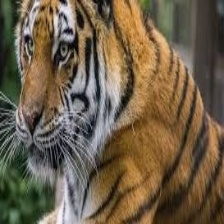

In [31]:
from IPython.display import Image
Image('./generated/generated-images-0025.png')